In [1]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import StepLR

# remove warnings (not nice :) )
import warnings
warnings.filterwarnings("ignore")

/Users/seriousmaria/anaconda3/envs/RL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# generate some mock data
nData = 200
x_train = np.random.uniform(low=0.0, high=1, size=(nData,))
y_train = 1-np.cos(2*np.pi*x_train)

x_test = np.sort(np.random.uniform(low=0.0, high=1.0, size=(50,)))
y_test = 1-np.cos(2*np.pi*x_test)
batch_size = 32

In [4]:
X_tensor = torch.tensor(x_train,dtype=torch.float)
y_tensor = torch.tensor(y_train,dtype=torch.float)
dataset = torch.utils.data.TensorDataset( X_tensor.unsqueeze(1), y_tensor)

training_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
class Net(nn.Module):
    def __init__(self, nInput, nOutput):
        super(Net, self).__init__()
        
        self.stack = nn.Sequential(
                nn.Linear(in_features=nInput, out_features=20),
                nn.ReLU(),
                nn.Linear(in_features=20, out_features=20),
                nn.ReLU(),
                nn.Linear(in_features=20, out_features=20),
                nn.ReLU(),
                nn.Linear(in_features=20, out_features=nOutput)
            )
            
    def forward(self, x):
            logits = self.stack(x)
            return logits

In [58]:
def train_one_epoch(epoch_index,model,loss_fn,debug=1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader,0):
        inputs, ytrue = data  

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, ytrue.unsqueeze(1))
        loss.backward()
        if debug == 1:
          if i == 0:
            grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
            for key in grads.keys():
                if key == "stack.0.weight":
                  print(f"{key}:{grads[key]}")

        # Update parameters
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    print(f"Loss:{running_loss/(i+1)}")
    return running_loss/(i+1)

# Impact of initialisation in neural networks

In [40]:
def init_weights_zero(m):
    if isinstance(m, nn.Linear):
          m.weight.data.fill_(0.0)
          m.bias.data.fill_(0.0)

def init_weights_constant(m):
    if isinstance(m, nn.Linear):
          m.weight.data.fill_(0.1)
          m.bias.data.fill_(0.1)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

In [41]:
for initialisation_type, initialisation in zip(['zeros','constant','xavier'],\
                                               [init_weights_zero, init_weights_constant, init_weights_xavier]):
  print(f"\nInitialisation: {initialisation_type}")
  model = Net(1,1)
  model.apply(initialisation)

  loss_fn = torch.nn.MSELoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

  for i in range(2):
    print(f"Epoch:{i}")
    _ = train_one_epoch(i,model,loss_fn,debug=1)



Initialisation: zeros
Epoch:0
stack.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss:5.001830101013184
Epoch:1
stack.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss:5.546699285507202

Initialisation: constant
Epoch:0
stack.0.weight:[0.04463819 0.04463819 0.04463819 0.04463819 0.04463819 0.04463819
 0.04463819 0.04463819 0.04463819 0.04463819 0.04463819 0.04463819
 0.04463819 0.04463819 0.04463819 0.04463819 0.04463819 0.04463819
 0.04463819 0.04463819]
Loss:2.722587466239929
Epoch:1
stack.0.weight:[0.05933565 0.05933565 0.05933565 0.05933565 0.05933565 0.05933565
 0.05933565 0.05933565 0.05933565 0.05933565 0.05933565 0.05933565
 0.05933565 0.05933565 0.05933565 0.05933565 0.05933565 0.05933565
 0.05933565 0.05933565]
Loss:2.2802194952964783

Initialisation: xavier
Epoch:0
stack.0.weight:[-0.01133307 -0.00404364 -0.0081841  -0.02376743 -0.00240874  0.01274255
  0.02493965  0.01082433 -0.0039224   0.00118894 -0.0170952   0.02197302

# Positivity of input

In [27]:
model = Net(1,1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

for i in range(10):
    print(f"Epoch:{i}")
    _ = train_one_epoch(i,model,loss_fn,debug=0)

Epoch:0
Loss:3.811567544937134
Epoch:1
Loss:3.1166136264801025
Epoch:2
Loss:2.3698932975530624
Epoch:3
Loss:2.4441241919994354
Epoch:4
Loss:2.753449261188507
Epoch:5
Loss:2.1699183583259583
Epoch:6
Loss:2.0750198662281036
Epoch:7
Loss:1.9868517220020294
Epoch:8
Loss:1.987475723028183
Epoch:9
Loss:2.4524479508399963


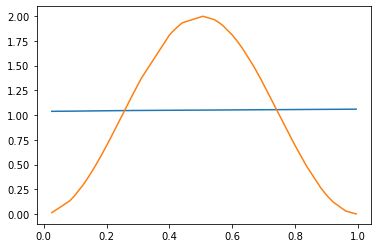

In [29]:
from matplotlib import pyplot as plt
y_pred = model(torch.tensor(x_test,dtype=torch.float).unsqueeze(1))
plt.plot(x_test,y_pred.detach().numpy())
plt.plot(x_test,y_test)

In [ ]:
# scale the inputs

In [30]:
x_train_scaled = x_train-0.5
X_tensor = torch.tensor(x_train_scaled,dtype=torch.float)
y_tensor = torch.tensor(y_train,dtype=torch.float)
dataset = torch.utils.data.TensorDataset( X_tensor.unsqueeze(1), y_tensor)

training_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [31]:
model = Net(1,1)
model.apply(init_weights_xavier)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

for i in range(10):
    print(f"Epoch:{i}")
    _ = train_one_epoch(i,model,loss_fn,debug=0)


Epoch:0
Loss:3.2399200201034546
Epoch:1
Loss:1.9675293564796448
Epoch:2
Loss:2.3609328269958496
Epoch:3
Loss:1.494763970375061
Epoch:4
Loss:0.8723941147327423
Epoch:5
Loss:0.5025689899921417
Epoch:6
Loss:0.25125008076429367
Epoch:7
Loss:0.3773432895541191
Epoch:8
Loss:0.249417532235384
Epoch:9
Loss:0.21150421351194382


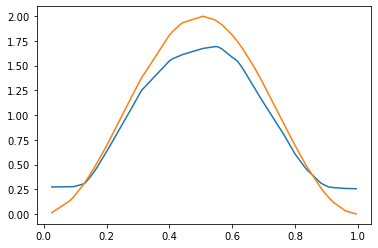

In [33]:
y_pred = model(torch.tensor(x_test-0.5,dtype=torch.float).unsqueeze(1))
plt.plot(x_test,y_pred.detach().numpy())
plt.plot(x_test,y_test)

# Early stopping

In [96]:
# generate val data
x_train_scaled = x_train-0.5
X_tensor = torch.tensor(x_train_scaled,dtype=torch.float)
y_tensor = torch.tensor(y_train,dtype=torch.float)
dataset = torch.utils.data.TensorDataset( X_tensor.unsqueeze(1), y_tensor)
training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x_val = np.random.uniform(low=0.0, high=1, size=(100,))
y_val = 1-np.cos(2*np.pi*x_train)
x_val_scaled = x_val - 0.5

X_val_t = torch.tensor(x_val_scaled,dtype=torch.float)
y_val_t = torch.tensor(y_val,dtype=torch.float)
dataset_val = torch.utils.data.TensorDataset( X_val_t.unsqueeze(1), y_val_t)

val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)

In [97]:
class EarlyStopping:
    def __init__(self, patience=1, burn_in= 10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.prev_validation =  float('inf')
        self.iter = 0
        self.burn_in = burn_in

    def stop(self, validation_loss):
        if self.iter > self.burn_in:
            self.iter += 1
            if validation_loss < self.prev_validation:
                self.prev_validation = validation_loss
                self.counter = 0
            elif validation_loss > (self.prev_validation + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        else:
            self.prev_validation = validation_loss
            self.iter += 1
            return False
    
def validation_loss_compute(validation_loader, model, loss_fn):
    running_loss = 0.
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
    return running_loss/(i+1)

model = Net(1,1)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_l = []
val_l = []
early_stopper = EarlyStopping(patience=5, min_delta=0.01,burn_in=10)
for epoch in np.arange(100):
    train_loss = train_one_epoch(epoch,model,loss_fn,debug=0)
    validation_loss = validation_loss_compute(val_loader, model, loss_fn)
    train_l.append(train_loss)
    val_l.append(validation_loss)
    print("Epoch: ", epoch, "Train loss:", train_loss, "Validation loss: ", validation_loss)
    if early_stopper.stop(validation_loss): 
        print("early stopping at epoch: ", epoch)            
        break
    

Loss:1.4128361344337463
Epoch:  0 Train loss: 1.4128361344337463 Validation loss:  0.8717281483113766
Loss:1.1943607330322266
Epoch:  1 Train loss: 1.1943607330322266 Validation loss:  0.9196278750896454
Loss:0.7983049675822258
Epoch:  2 Train loss: 0.7983049675822258 Validation loss:  0.7771755456924438
Loss:0.7091645002365112
Epoch:  3 Train loss: 0.7091645002365112 Validation loss:  0.6817821562290192
Loss:0.5801646336913109
Epoch:  4 Train loss: 0.5801646336913109 Validation loss:  0.5223766416311264
Loss:0.490474596619606
Epoch:  5 Train loss: 0.490474596619606 Validation loss:  0.5103840529918671
Loss:0.4490251690149307
Epoch:  6 Train loss: 0.4490251690149307 Validation loss:  0.4465390332043171
Loss:0.5323442071676254
Epoch:  7 Train loss: 0.5323442071676254 Validation loss:  0.6059219241142273
Loss:0.47028926759958267
Epoch:  8 Train loss: 0.47028926759958267 Validation loss:  0.5429791510105133
Loss:0.5370874404907227
Epoch:  9 Train loss: 0.5370874404907227 Validation loss: 

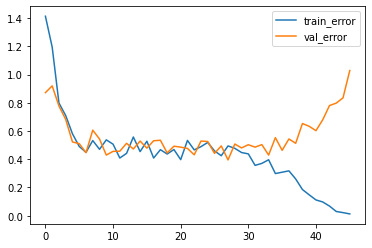

In [98]:
plt.plot(train_l,label='train_error')
plt.plot(val_l,label='val_error')
plt.legend()

# Nonlinear transformations

In [2]:
# Visualising the n-1 layer transformations of the input

In [8]:
class Net(nn.Module):
    def __init__(self, nInput, nOutput):
        super(Net, self).__init__()
        
        self.stack = nn.Sequential(
                nn.Linear(in_features=nInput, out_features=100),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=50),
                nn.ReLU(),
                nn.Linear(in_features=50, out_features=50),
                nn.ReLU(),
                nn.Linear(in_features=50, out_features=30),
                nn.ReLU(),
                nn.Linear(in_features=30, out_features=20),
                nn.ReLU()
            )
        
        self.output = nn.Sequential(nn.Linear(in_features=20,out_features=1))
            
    def forward(self, x):
            logits = self.stack(x)
            return self.output(logits)
        
    def reveal(self,x):
        return self.stack(x)

In [9]:
nData = 1000
x_train = np.random.uniform(low=-1.0, high=1, size=(nData,))
y_train = np.cos(2*np.pi*x_train)
batch_size=64

X_tensor = torch.tensor(x_train,dtype=torch.float)
y_tensor = torch.tensor(y_train,dtype=torch.float)
dataset = torch.utils.data.TensorDataset( X_tensor.unsqueeze(1), y_tensor)

training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [14]:
model = Net(1,1)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

# train model
for epoch in range(40):
    running_loss = 0.
    for i, data in enumerate(training_loader,0):
        inputs, ytrue = data  

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, ytrue.unsqueeze(1))
        loss.backward()

        # Update parameters
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch: {epoch} Loss:{running_loss/(i+1)}")


Epoch: 0 Loss:8.855804232880473
Epoch: 1 Loss:0.503267427906394
Epoch: 2 Loss:0.4848663043230772
Epoch: 3 Loss:0.47114528715610504
Epoch: 4 Loss:0.45109869353473186
Epoch: 5 Loss:0.3641939861699939
Epoch: 6 Loss:0.12865572050213814
Epoch: 7 Loss:0.03562809177674353
Epoch: 8 Loss:0.01599536358844489
Epoch: 9 Loss:0.006492820073617622
Epoch: 10 Loss:0.00643910288636107
Epoch: 11 Loss:0.0029792790301144123
Epoch: 12 Loss:0.002982493839226663
Epoch: 13 Loss:0.0021268200362101197
Epoch: 14 Loss:0.0022194054145074915
Epoch: 15 Loss:0.002351356510189362
Epoch: 16 Loss:0.0033200441612279974
Epoch: 17 Loss:0.001837907031585928
Epoch: 18 Loss:0.001362320519547211
Epoch: 19 Loss:0.0011050817265640944
Epoch: 20 Loss:0.0012296648674237076
Epoch: 21 Loss:0.0011707278572430369
Epoch: 22 Loss:0.0013768485914624762
Epoch: 23 Loss:0.0008986070170067251
Epoch: 24 Loss:0.001060620961652603
Epoch: 25 Loss:0.004385812018881552
Epoch: 26 Loss:0.0031309783007600345
Epoch: 27 Loss:0.001979450709768571
Epoch: 2

In [19]:
x_uniform = np.linspace(-1,1,100)

features = model.reveal(torch.tensor(x_uniform,dtype=torch.float).unsqueeze(1))
y_pred = model(torch.tensor(x_uniform,dtype=torch.float).unsqueeze(1))

In [20]:
features_np = features.detach().numpy()

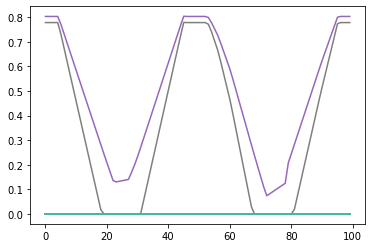

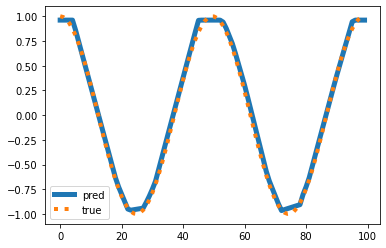

In [21]:
from matplotlib import pyplot as plt
for i in range(10):
    plt.plot(features_np[:,i])
    
plt.figure()
plt.plot(y_pred.detach().numpy(),lw=5,label='pred')
plt.plot(np.cos(2*np.pi*x_uniform),lw=4,ls='dotted',label='true')
plt.legend()